In [44]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Check for null values

In [4]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

### Split features and labels

In [6]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[classes].values
X_train = train["comment_text"]
X_test = test["comment_text"]

### Parameters

In [51]:
max_features = 20000
maxlen = 200
embed_size = 128
lstm_units = 60
dropout_rate = 0.1
batch_size = 32
epochs = 2

### Tokenize sentences


1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]

2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}

3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [7]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

In [23]:
#for occurence of words
#tokenizer.word_counts

#for index of words
#tokenizer.word_index

#for tokenized sentences
#X_train_tokenized

In [24]:
X_train_padded = pad_sequences(X_train_tokenized, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=maxlen)

(array([21439., 27127., 22176., 16223., 12859., 10062.,  7586.,  5991.,
         4731.,  3914.,  3129.,  2820.,  2306.,  1896.,  1647.,  1455.,
         1329.,  1287.,  1013.,   857.,   750.,   799.,   528.,   581.,
          486.,   437.,   407.,   373.,   386.,   292.,   284.,   242.,
          217.,   169.,   156.,   167.,   158.,   133.,   136.,   116.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

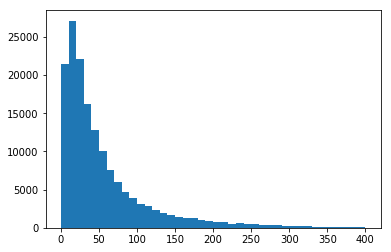

In [42]:
commentLenghts = [len(comment) for comment in X_train_tokenized]
plt.hist(commentLenghts ,bins = np.arange(0,410,10))

In [54]:
model = Sequential()
model.add(Embedding(max_features, embed_size, input_length=maxlen))
model.add(LSTM(lstm_units, return_sequences=True, name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(dropout_rate))
model.add(Dense(50, activation="relu", name='hidden_dense'))
model.add(Dropout(dropout_rate))
model.add(Dense(6, activation="sigmoid", name='output_layer'))

In [55]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [56]:
model.fit(X_train_padded, y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 600s 4ms/step - loss: 0.0717 - acc: 0.9773 - val_loss: 0.0491 - val_acc: 0.9820
Epoch 2/2
143613/143613 [==============================] - 627s 4ms/step - loss: 0.0449 - acc: 0.9832 - val_loss: 0.0481 - val_acc: 0.9820


In [58]:
model.predict(X_test_padded)

array([[9.9734575e-01, 4.7494662e-01, 9.7110903e-01, 9.8895624e-02,
        8.9235431e-01, 2.2487409e-01],
       [1.3096425e-03, 3.5660909e-07, 1.3003877e-04, 2.6011598e-06,
        5.3588796e-05, 3.6784661e-06],
       [2.1484382e-03, 1.2998494e-06, 2.5288280e-04, 8.3412097e-06,
        1.0098260e-04, 1.0904772e-05],
       ...,
       [3.2246168e-04, 6.8290014e-08, 4.6930898e-05, 2.8904185e-07,
        9.9540994e-06, 8.7622061e-07],
       [2.2075316e-03, 3.9446827e-06, 2.9565874e-04, 2.4915236e-05,
        1.3006567e-04, 5.6170018e-05],
       [9.7671640e-01, 2.9082173e-02, 8.6929590e-01, 4.2702719e-03,
        5.0274843e-01, 1.5965061e-02]], dtype=float32)

In [59]:
X_test_padded

array([[   0,    0,    0, ...,  145,  493,   84],
       [   0,    0,    0, ...,   11,    8, 2826],
       [   0,    0,    0, ...,  109,   15,  355],
       ...,
       [   0,    0,    0, ...,   12, 1652,  358],
       [   0,    0,    0, ..., 9844, 3506,  355],
       [   0,    0,    0, ...,  100, 5220,    6]])

In [74]:
custom_sentences = ['Veronika likes pushing people in the metro. Dont stand to the left in the escalator or you will get pushed in the back!']
custom_sentences = tokenizer.texts_to_sequences(custom_sentences)
custom_sentences = pad_sequences(custom_sentences, maxlen=maxlen)
predictions = model.predict(custom_sentences)

In [75]:
predictions
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pd.DataFrame(data=predictions, columns=columns)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.004198,0.000003,0.000364,0.00003,0.000217,0.000031
